Import required libraries

In [22]:
import pandas as pd
import googlemaps
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt


Merge the "Cost of Living" csv file with the "Cost of Living Columns" csv file. Filter the list to show only the top 10 cities of interest.

In [23]:
# Load CSV files
livingcosts_df = pd.read_csv("data/cost-of-living.csv")
headers_df = pd.read_csv("data/Cost_of_Living_Columns.csv",sep='\t')
headers_df.columns = headers_df.columns.str.strip().str.lower()

# Create diction9ary to map the headers to the main data file
key_to_header = dict(zip(headers_df['column'], headers_df['description']))

# Replace the headers in the main data file with descriptions from the mapping
livingcosts_df.columns = [key_to_header.get(col, col) for col in livingcosts_df.columns]

# Filter the dataframe to only show US & Canada data
livingcosts_df = livingcosts_df[
    (livingcosts_df["Name of the country"] == "United States") |
    (livingcosts_df["Name of the country"] == "Canada")
    ]

# Filter the dataframe to only show cities we are interested in viewing
livingcosts_df = livingcosts_df[
    (livingcosts_df["Name of the city"] == "Ann Arbor") |
    (livingcosts_df["Name of the city"] == "Detroit") |
    (livingcosts_df["Name of the city"] == "Dayton") |
    (livingcosts_df["Name of the city"] == "Columbus") |
    (livingcosts_df["Name of the city"] == "Cincinnati") |
    (livingcosts_df["Name of the city"] == "Guelph") |
    (livingcosts_df["Name of the city"] == "London") |
    (livingcosts_df["Name of the city"] == "Cambridge") |
    (livingcosts_df["Name of the city"] == "Vaughan") |
    (livingcosts_df["Name of the city"] == "Kitchener")
    ]

# Save the updated DataFrame to new CSV file
livingcosts_df.to_csv('data/updated_living_costs.csv', index=False)

print(livingcosts_df[['Apartment (3 bedrooms) Outside of Centre (USD)','Basic (Electricity, Heating, Cooling, Water, Garbage) for 85m2 Apartment (USD)','Internet (60 Mbps or More, Unlimited Data, Cable/ADSL) (USD)']])

      Apartment (3 bedrooms) Outside of Centre (USD)  \
146                                          1666.67   
278                                          1485.00   
295                                          1673.00   
474                                          1657.82   
662                                          1225.00   
1068                                         1578.98   
1205                                         2427.50   
1234                                         2233.58   
2187                                         1909.30   
2210                                         1377.38   

      Basic (Electricity, Heating, Cooling, Water, Garbage) for 85m2 Apartment (USD)  \
146                                              249.06                                
278                                              127.96                                
295                                              183.48                                
474                            

Create new columns to summarize monthly living expenses & lifestyle expenses

In [24]:
#calculate monthly costs of rent, utilites, and internet
livingcosts_df['Monthly Expenses']=livingcosts_df[['Apartment (3 bedrooms) Outside of Centre (USD)','Basic (Electricity, Heating, Cooling, Water, Garbage) for 85m2 Apartment (USD)','Internet (60 Mbps or More, Unlimited Data, Cable/ADSL) (USD)']].sum(axis=1)

#calculate cost of 2 people going out for dinner and drinks one night
livingcosts_df['Night out cost']=livingcosts_df['Meal for 2 People, Mid-range Restaurant, Three-course (USD)']+livingcosts_df['Domestic Beer (0.5 liter bottle, at the market) (USD)']*8

# Save the updated DataFrame to new CSV file
livingcosts_df.to_csv('data/updated_living_costs.csv', index=False)

Use Google Maps API Client to pull in distances of top 10 cities to the main visit destinations

In [25]:
# Initialize Google Maps API client
api_key = 'your key'
gmaps = googlemaps.Client(key=api_key)


# List of cities and reference points
cities = [
    "Ann Arbor, MI",
    "Detroit, MI",
    "Columbus, OH",
    "Cincinnati, OH",
    "Dayton, OH",
    "Guelph, ON",
    "London, ON",
    "Cambridge, ON",
    "Kitchener, ON",
    "Vaughan, ON"
]

reference_points = ["Guelph, ON", "St. Henry, OH"]

# Function to get driving distance
def get_driving_distance(origin, destination):
    try:
        result = gmaps.distance_matrix(origins=origin, destinations=destination, mode="driving", departure_time=datetime.now())
        distance = result['rows'][0]['elements'][0]['distance']['text']
        return distance
    except Exception as e:
        print(f"Error getting distance from {origin} to {destination}: {e}")
        return "Error"
# Prepare a DataFrame to store results
results = []

# Calculate distances
for city in cities:
    # Create a dictionary for the current city
    city_distances = {'City': city}
    for point in reference_points:
        distance = get_driving_distance(city, point)
        # Add the distance to the dictionary with the appropriate key
        city_distances[f'Distance to {point.split(",")[0]}'] = distance
    # Append the city distances dictionary to results
    results.append(city_distances)

# Create a DataFrame from the results
distances_df = pd.DataFrame(results)

# Function to convert distances to numeric values (in km), considering '1 m' as 0.001 km
def convert_to_km(distance_str):
    if 'km' in distance_str:
        return float(distance_str.replace(' km', '').replace(',', ''))
    elif 'm' in distance_str:
        return 0.001  # Converting 1 meter to kilometers
    return None

# Apply the conversion function to the DataFrame
distances_df['Distance to Guelph (km)'] = distances_df['Distance to Guelph'].apply(convert_to_km)
distances_df['Distance to St. Henry (km)'] = distances_df['Distance to St. Henry'].apply(convert_to_km)

distances_df = distances_df[['City', 'Distance to Guelph (km)', 'Distance to St. Henry (km)']]

#remove the province/state to make it match the other data file
distances_df['City'] = distances_df['City'].str.split(',').str[0]

print(distances_df)

         City  Distance to Guelph (km)  Distance to St. Henry (km)
0   Ann Arbor                  382.000                       278.0
1     Detroit                  300.000                       300.0
2    Columbus                  623.000                       175.0
3  Cincinnati                  720.000                       192.0
4      Dayton                  634.000                       106.0
5      Guelph                    0.001                       596.0
6      London                  120.000                       491.0
7   Cambridge                   23.500                       577.0
8   Kitchener                   25.200                       586.0
9     Vaughan                   87.100                       665.0


Merge the Monthly Expenses & Night out cost columns to the datafame

In [26]:
livingcosts_df.rename(columns={'Name of the city': 'City'}, inplace=True)

# Perform the merge
summary_df = distances_df.merge(
    livingcosts_df[['City', 'Gasoline (1 liter) (USD)', 'Monthly Expenses', 'Night out cost']], 
    on='City', 
    how='left'
)

summary_df['Gasoline (1 liter) (USD)']=summary_df['Gasoline (1 liter) (USD)']*3.78541

print(summary_df)

         City  Distance to Guelph (km)  Distance to St. Henry (km)  \
0   Ann Arbor                  382.000                       278.0   
1     Detroit                  300.000                       300.0   
2    Columbus                  623.000                       175.0   
3  Cincinnati                  720.000                       192.0   
4      Dayton                  634.000                       106.0   
5      Guelph                    0.001                       596.0   
6      London                  120.000                       491.0   
7   Cambridge                   23.500                       577.0   
8   Kitchener                   25.200                       586.0   
9     Vaughan                   87.100                       665.0   

   Gasoline (1 liter) (USD)  Monthly Expenses  Night out cost  
0                  4.428930           2652.38          100.96  
1                  4.845325           1986.40           74.88  
2                  4.315367          

Generate a bar chart that compares the driving distance between the top 10 cities and the hometowns.

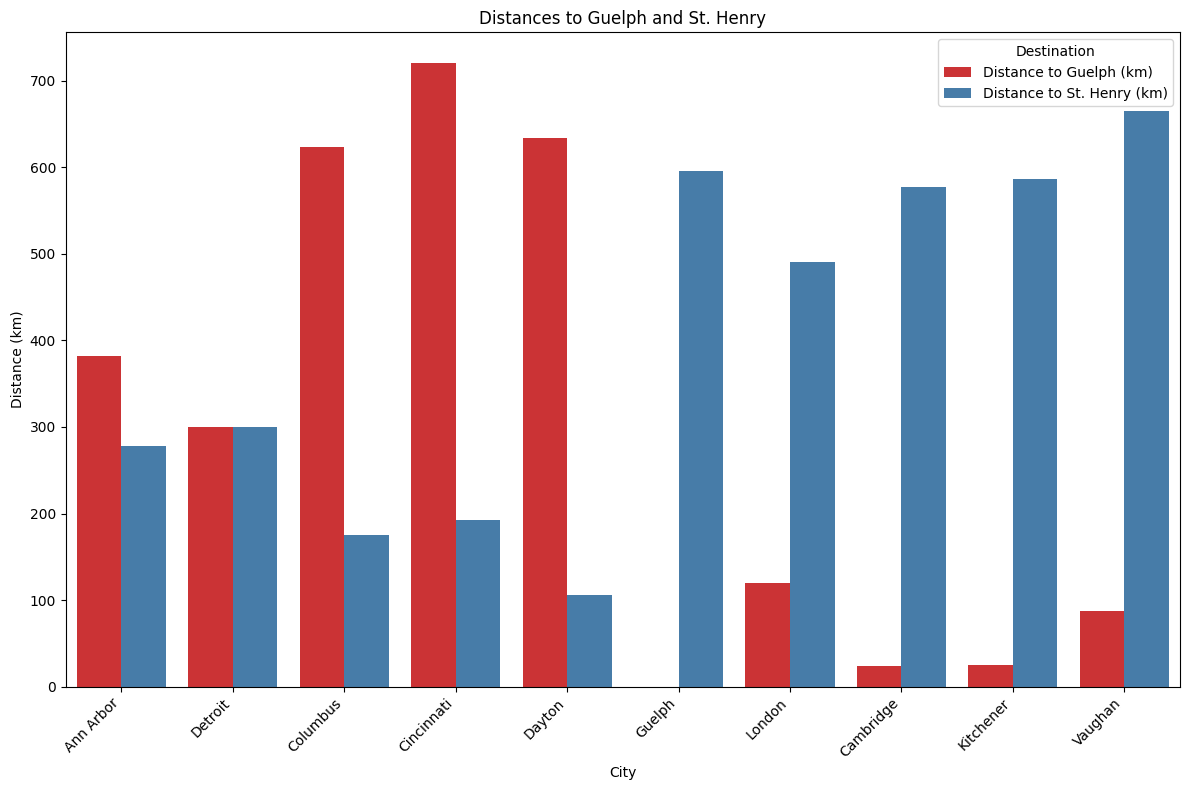

In [27]:
# Melt the DataFrame to long format
df_melted = summary_df.melt(id_vars='City', value_vars=['Distance to Guelph (km)', 'Distance to St. Henry (km)'],
                    var_name='Destination', value_name='Distance')

# Plot using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(data=df_melted, x='City', y='Distance', hue='Destination', palette='Set1')
plt.xticks(rotation=45, ha='right')
plt.title('Distances to Guelph and St. Henry')
plt.xlabel('City')
plt.ylabel('Distance (km)')
plt.legend(title='Destination')
plt.tight_layout()
plt.show()

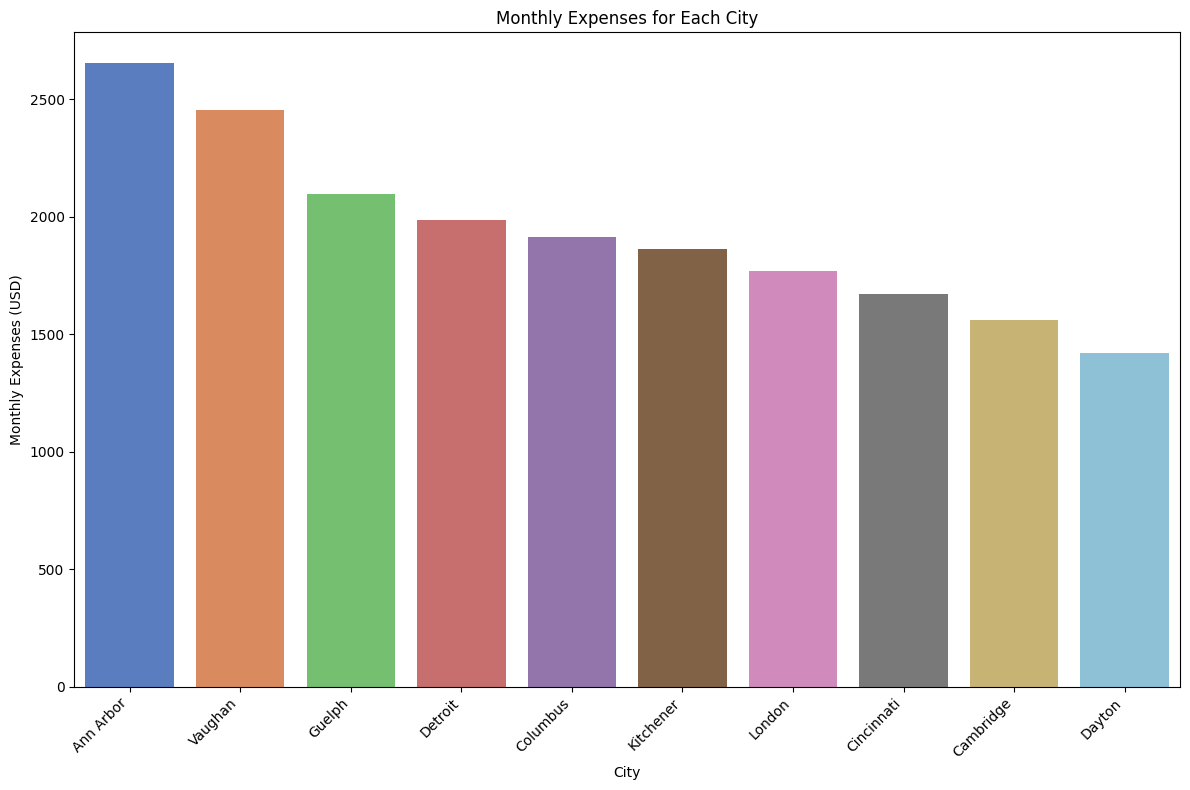

In [28]:
#sort the dataframe so highest expenses are first
df_sorted = livingcosts_df.sort_values(by='Monthly Expenses', ascending=False)

# Set the size of the figure
plt.figure(figsize=(12, 8))

# Create a bar chart with seaborn
sns.barplot(x='City', y='Monthly Expenses', data=df_sorted,hue='City', palette='muted')

# Add title and labels
plt.title('Monthly Expenses for Each City')
plt.xlabel('City')
plt.ylabel('Monthly Expenses (USD)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

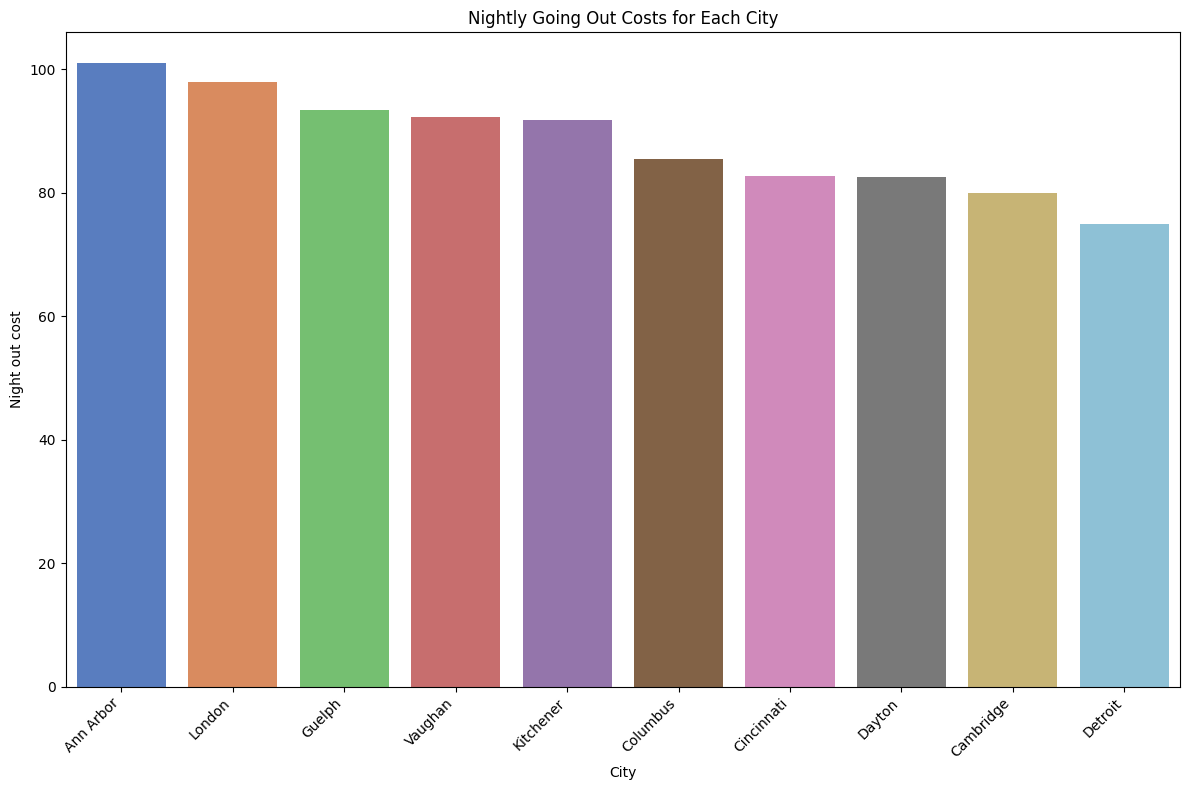

In [29]:
#sort the dataframe so highest expenses are first
df_sorted = livingcosts_df.sort_values(by='Night out cost', ascending=False)

# Set the size of the figure
plt.figure(figsize=(12, 8))

# Create a bar chart with seaborn
sns.barplot(x='City', y='Night out cost', data=df_sorted,hue='City', palette='muted')

# Add title and labels
plt.title('Nightly Going Out Costs for Each City')
plt.xlabel('City')
plt.ylabel('Night out cost')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()